# The instrument response and the source injector

In the previous tutorials, we had been playing with monoenergetic sources. Let's now simulate a "continuous" source. We'll use a power law spectrum:

$$F(E) = F_0 \left(\frac{E}{E_0}\right)^\alpha \,,$$

where $F_0$ is the flux at an arbitrary energy $E_0$ --called the pivot energy-- and $\alpha$ is the spectral index.

A power law looks like a line in a log-log plot, and it's usually a good approximation for an astrophysical source over a not-so-large energy range.

Here we plot a power law between 200 keV and 50 MeV, the approximate energy range of our made-up COMPTELito traditional detector: 

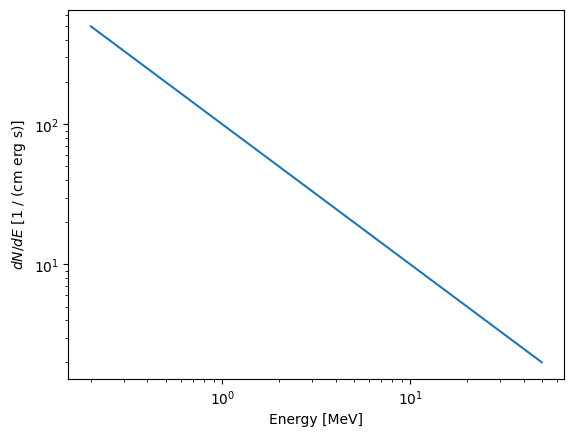

In [1]:
from gammaraytoys.detectors import PowerLawSpectrum, PointSource
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = PowerLawSpectrum(index = -1, 
                                                min_energy = 200*u.keV,
                                                max_energy = 50*u.MeV),
                     flux_pivot = 1e2/u.erg/u.cm/u.s,
                     pivot_energy = 1*u.MeV)

source.plot_spectrum();

There are a few particular spectral index values that are worth remembering:
- $\alpha = 0$: Uniform probability
- $\alpha = -1$: Equal particle flux per decade in energy
- $\alpha = -2$: Equal energy flux per decade in energy. 

The following simulation will randomly sample the energy of the primary from the above distribution and shoot it at the detector. The measured energies will then be binned into a histogram.

100%|██████████| 3325/3325 [00:28<00:00, 115.74it/s]

We simulated 3.6e+03 s (3325) and detected 1062


Text(0, 0.5, 'Counts')

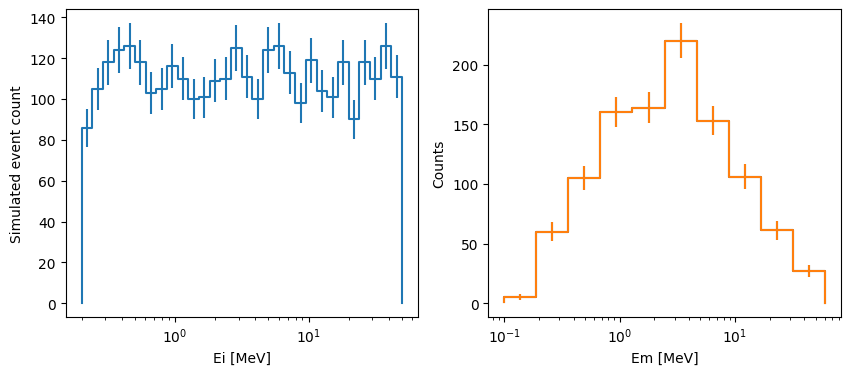

In [2]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u
from gammaraytoys.detectors import Simulator, SimpleTraditionalReconstructor
from gammaraytoys.detectors import PointSource, MonoenergeticSpectrum
import matplotlib.pyplot as plt

# Detector 
det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)

# Getting Em and the CDS
reco = SimpleTraditionalReconstructor()

# Sims, where "source" is the point source whose spectrum was plotted above
sims = Simulator(detector = det, 
                 sources = source, 
                 reconstructor = reco)

# Let's change the binning default since we're looking
# at a "continuum" source --i.e. with no narrow energy lines
# The photon energy axis covers the whole energy
# of our detector
# We make the measured energy axis slightly wider in order to 
# capture the spread in energy due to measurement errors.
sims.photon_energy_axis = np.geomspace(200*u.keV, 50*u.MeV, 31)
sims.measured_energy_axis = np.geomspace(100*u.keV, 60*u.MeV, 11)

# We'll simulate enough even to effectively covert one hour of observations
# The simulations are performed event by event inside, and the output is
# returned already binned, in both real and measured energy
# h_data contains only triggered events, while h_nsim contains all thrown events whether
# they triggered or not
duration = 1*u.hour
h_data, h_nsim = sims.run_binned(duration = duration, axes = 'Em', photon_axes = 'Ei')

# Summary and plot, projected into the measured energy axis
print(f"We simulated {sims.duration:.2} ({sims.nsim}) and detected {sims.ntrig}")

fig,ax = plt.subplots(figsize = [10,4], ncols = 2)

# All simulated events
h_nsim.plot(ax[0], errorbars = True)
ax[0].set_ylabel('Simulated event count')

# Only triggered events, projected on the measured energy axis
h_Em = h_data.project('Em')
h_Em.plot(ax[1], errorbars = True)
h_data.project('Em').plot(ax[1], errorbars = True)
ax[1].set_ylabel('Counts')

The number of simulated event per energy bin is flat since we simulated a $alpha = -1$ source and the bins are logairthmic. The measured energy distribution does not look like the thrown energy distribution due to a combination of the energy-dependent effective area and the energy dispersion. Since in the simulations we tracked the real photon energy, we can see exactly how the energy dispersion matrix looks like and how the photons "migrated" between energy bins: 

Text(0, 0.5, 'Counts')

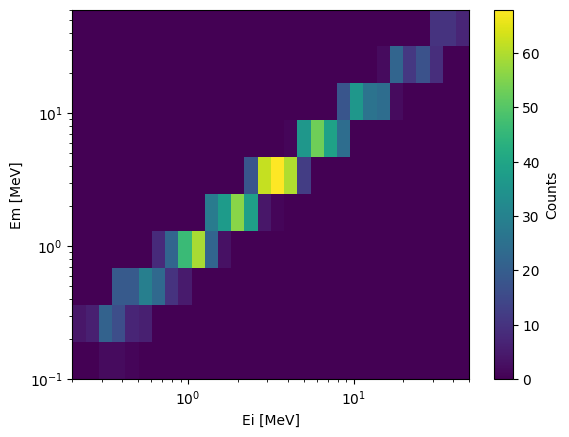

In [3]:
ax,_ = h_data.plot()
ax.get_figure().axes[-1].set_ylabel("Counts")

## The instrument response matrix

The "instrument response function" describes two things: how likely it is to detect an eventencoded the effective area) ad what the probability of a detected event of energy $Ei$ to be measured as $Em$ . That is

$$R(E_m; E_i) = A_{eff}(E_i) P(E_m | E_i) $$

When we work with binned data, what we actually use is the discretized version of the response function, that is:

$$R(\Delta E_m; E_i) = \textstyle \int_{\Delta E_m} R(E'; E_i) dE' $$

The matrix in the previous section is quite close. Since we threw events base on a specific spectrum, which we'll call $F_0(E_i)$, the average counts of each bin should be:

$$ N_{expected}(\Delta E_m; \Delta E_i) = \left<N_{trig}(\Delta E_m; \Delta E_i) \right> = \Delta t \int_{\Delta E_i} R(\Delta E_m; E) F_0(E) dE $$

As long as the $Ei$ bins are sufficiently small, we can approximate $R(\Delta E_m; E_i)$ by dividing $N_{trig}(\Delta E_m; \Delta E_i)$ by the number of thrown event on each $E_i$ bin:

$$\frac{\left<N_{trig}(\Delta E_m; \Delta E_i) \right>}{\left<N_{sim}(\Delta E_i)\right>} = \frac{\Delta t\int_{\Delta E_i} R(\Delta E_m; E) F_0(E) dE}{\Delta t\int_{\Delta E_i}A_{thrown}(E) F_0(E) dE} \approx \frac{\Delta t  R(\Delta E_m; E_i) \int_{\Delta E_i}  F_0(E) dE}{\Delta t A_{thrown}(E_i)\int_{\Delta E_i} F_0(E) dE} = \frac{R(\Delta E_m; E_i)}{A_{thrown}(E_i)} \,,$$

where $E_i$ is the center of a $\Delta E_i$ bin. 

Following this prescription, we'll compute the estimated response matrix in the following cell. Since this requires many more events, in order to reduce the effect of statistical fluctuation, you can leave this running for a few minutes or instead load the pre-computed matrix. 

In [4]:
%%time

create_my_own = False

if create_my_own:
    
    # These are N_trig(Delta Em, Delta Ei) and N_sim(Delta Ei)
    h_data_rsp, h_nsim_rsp = sims.run_binned(ntrig = 10000, axes = 'Em', photon_axes = 'Ei')
    
    # This is our approximation of R(Delta Em, Ei)
    response = h_data_rsp * (det.throwing_plane_size / h_nsim_rsp.contents)[:,None] 
    
else:

    from histpy import Histogram
    response = Histogram.open("instrument_response/response_energy_onaxis_traddet.h5")

CPU times: user 5.9 ms, sys: 3.1 ms, total: 9 ms
Wall time: 8.82 ms


The resulting matrix, called the detector response matrix, looks like this:

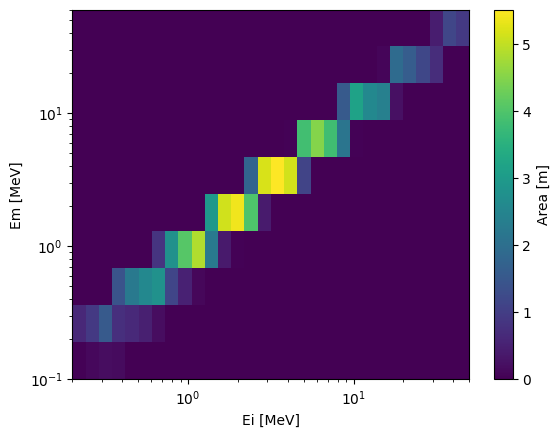

In [5]:
ax,_ = response.plot()
ax.get_figure().axes[-1].set_ylabel(f"Area [{response.unit}]");

It now has units of area. If you project it into the $Ei$ it will give you the total effective area:

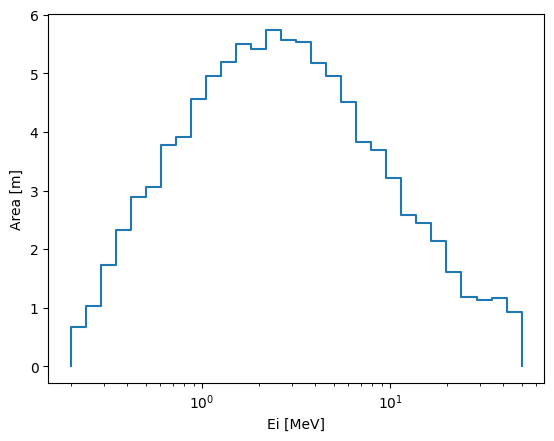

In [6]:
Aeff = response.project('Ei')
ax,_ = Aeff.plot()
ax.set_ylabel(f"Area [{response.unit}]");

If you divide each column by the effective area, it will give the energy dispersion matrix, normalized to 1 along each column:

/Users/israel/work/software/histpy/histpy/histogram.py:1489: RuntimeWarning: invalid value encountered in divide
  self._contents = operation(self.full_contents, other)


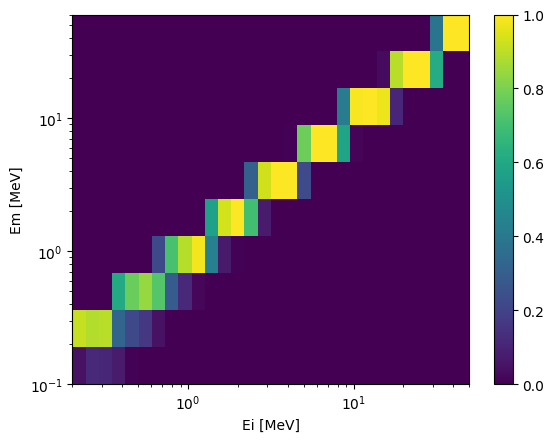

In [7]:
energy_dispersion = response/Aeff.contents[:,None]#response.project('Ei').contents[:,None]
energy_dispersion.plot();

## Using the response matrix

The great power of the response matrix is that it allows us to quickly simulate a source without having to run the photon-by-photon simulations, which are CPU-intensive. The expected counts from a source with spectrum $F(E)$ can be computed as:

$$ N_{expected}(\Delta E_m) = \Delta t \int_0^{\infty} R(\Delta E_m; E) F(E) dE $$

If the $E_i$ bins are sufficiently small, we can approximate this integral as

$$ N_{expected}(\Delta E_m) \approx \Delta t \sum_j R(\Delta E_m; E_{i_j}) \int_{\Delta E_{i_j}} F(E) dE \,,$$

where the $j$ index loops through all photon energy bins, which should fully cover the energy range of the detector.

This only works well if the photon energy bin $\Delta E_i$ is sufficiently small. How small they need to be depends on the energy resolution and how far the spectrum $F(E)$ differs from the thrown spectrum $F(E_0)$ we used to estimate $R(\Delta E_m, E_i)$. In fact, when $F(E) = F_0(E)$ then this approximation becomes exact.  Typically you have to perform a simulation to know if the $E_i$ bins are small to reproduce the counts that you obtain from the photon-by-photon simulations.

Note that the $\Delta E_m$ can have any size you want. Coarse $E_m$ bins will reduce your sensitivity and increase your statistical measurement error, but the result will still be correct. In fact, $E_m$ does not even need to be the actual measurement energy, any variable that is correlated with energy would do. 

The sum above can be written as a dot product, which is useful since dot products are fast to compute.

<div>
<img src="../figures/respose_dot_model.png" width="500"/>
</div>

The array $M_j = \int_{\Delta E_{i_j}} F(E) dE$ is the discretized or binned version of spectrum $F(E)$. It is usually called "the model". Here's how it looks for our spectrum above:

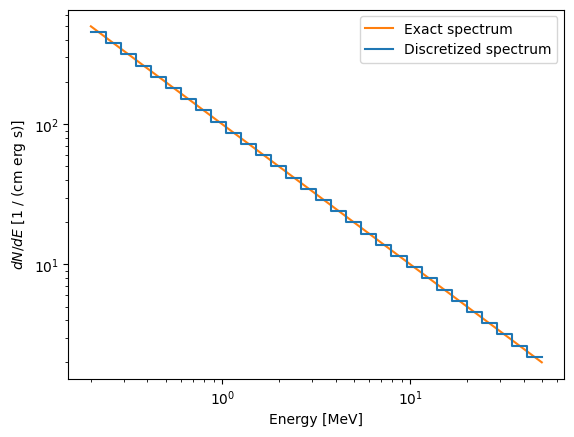

In [8]:
from histpy import Histogram

y_units = 1/u.erg/u.cm/u.s

# Obtain the binned version by integrating over the energy bins
binned_spec = source.discretize_spectrum(response.axes['Ei'])

# Divide by the energy bin width, effectively getting an average
ax,_ = (binned_spec / binned_spec.axis.widths).to(y_units).plot(label = 'Discretized spectrum')

# Exact
source.plot_spectrum(ax, label = 'Exact spectrum', y_units = y_units);

ax.legend();

Let's now use the response to compute the expected counts from this spectrum. Or in common parlance, let's "convolve the model with the detector response". Compare the time it takes to perform this calculation to the photon-by-photon simulations!

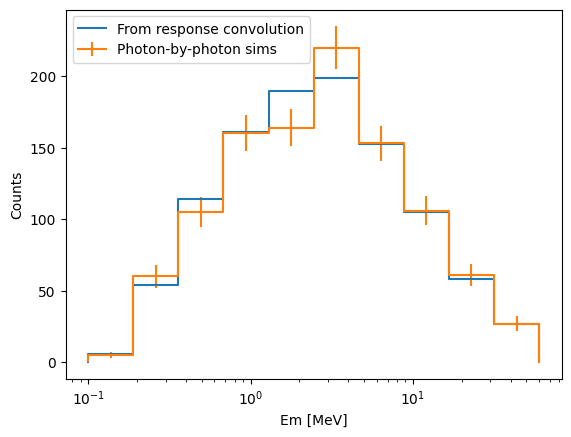

In [9]:
# Convolution
expected_counts = np.dot(response.contents.transpose(), duration*binned_spec.contents).to_value('')

h_Em_from_response = Histogram(response.axes['Em'], contents = expected_counts)

# Plotting
fig,ax = plt.subplots()
h_Em_from_response.plot(ax, label = "From response convolution")

# Comparison to event-by-event sims
h_Em.plot(ax, errorbars = True, label = "Photon-by-photon sims")

ax.set_ylabel('Counts')
ax.legend();

## Source injector

The result from detector response convolution is the average number of expected counts, while if this were real data it would have fluctuations. If you want to simulate this effect and "inject" a source that looks the same as real data you can simply Poisson-fluctuate the result. We use the Poisson distribution because that's how independent events are distributed. That is, there is a built-in but usually safe assumption that the events are not correlated, whether it is because of the way they were emitted or due to instrumental effects.

Try tunning the next cell several times to get a sense of the variations:

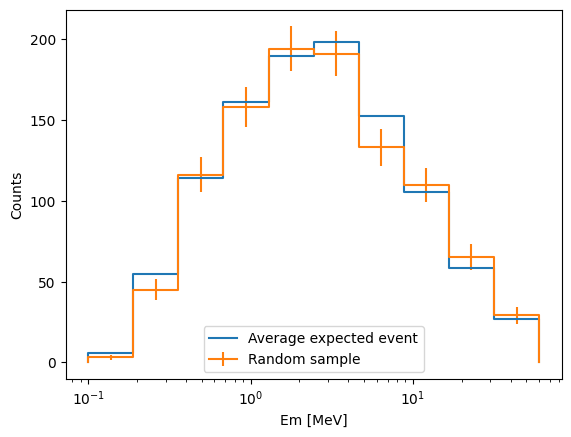

In [10]:
# Mean expected counts
fig,ax = plt.subplots()
h_Em_from_response.plot(ax, label = "Average expected event")

# Poisson fluctuate
h_Em_random = Histogram(h_Em_from_response.axis, np.random.poisson(h_Em_from_response.contents))

h_Em_random.plot(ax, errorbars = True, label = "Random sample")

ax.set_ylabel('Counts')
ax.legend();

## Wraping things up

The code above was packaged into the `SpectralResponse` class. Here's how to use it:

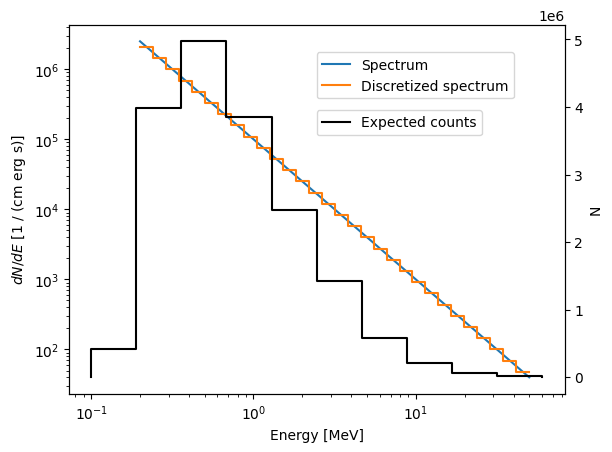

In [11]:
from gammaraytoys.detectors import PowerLawSpectrum, PointSource
from gammaraytoys.analysis import SpectralResponse
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = PowerLawSpectrum(index = -2, 
                                                min_energy = 200*u.keV,
                                                max_energy = 50*u.MeV),
                     flux_pivot = 1e5/u.erg/u.cm/u.s,
                     pivot_energy = 1*u.MeV)

response = SpectralResponse.open("instrument_response/response_energy_onaxis_traddet.h5")

expected_counts = response.expected_counts(source, 1*u.day)

fig,axl = plt.subplots()

source.plot_spectrum(axl, label = 'Spectrum');
source.plot_spectrum(axl, discretize_axis = response.photon_energy_axis, label = 'Discretized spectrum');
axl.legend(loc = (.5,.8))

axr = axl.twinx()
expected_counts.plot(axr, color = 'black', label = 'Expected counts')
axr.set_ylabel("N")
axr.legend(loc = (.5,.7));

<div class="alert alert-block alert-info">
<b>Exercise: </b>
    
- Simulate sources with various spectral indices, both using the response matrix and photon-by-photon simulations. Try to  find the point at which our assumptions break and the detector response can no longer reproduce the photon-by-photon simulations
- Repeat the exercise above for a monochromatic source. Can you identify any systematic issues?
</div>